In [1]:
## XGBoost 
# State 1 hot 
# Rurality Data
# SVI poverty index
# Minority?


In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [218]:
main_path = Path.cwd().parent.parent
data_path = main_path / 'Data'

#svi = pd.read_csv( data_path / 'Master Project Data' /'SVI Tract Data.csv',  )


In [280]:
# import stored methods 
path = Path.cwd().parent.parent
LoadAndCleanACS = main_path /'src' /'data'/ 'LoadAndCleanACS.py'
LoadAndCleanARCP = main_path /'src' /'data'/ 'LoadAndCleanARCP.py'

# Run methods to obtain clean datasets 
%run $LoadAndCleanACS
%run $LoadAndCleanARCP


                     Pair Var 1                    Pair Var 2  Corr Value
59         house_pct_non_family          house_pct_live_alone    0.907753
25               race_pct_white              race_pct_whitenh    0.851387
36            race_pct_nonwhite           race_pct_nonwhitenh    0.851387
37            race_pct_nonwhite                race_pct_black    0.802072
48             house_pct_family      house_pct_family_married    0.757961
104    house_pct_complete_plumb    house_pct_complete_kitchen    0.752488
109  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.752488
92         heat_pct_utility_gas          heat_pct_electricity   -0.732439
105    house_pct_complete_plumb  house_pct_incomplete_kitchen   -0.752488
108  house_pct_incomplete_plumb    house_pct_complete_kitchen   -0.752488
53     house_pct_family_married          house_pct_non_family   -0.757961
28               race_pct_white                race_pct_black   -0.802072
31             race_pct_whitenh       

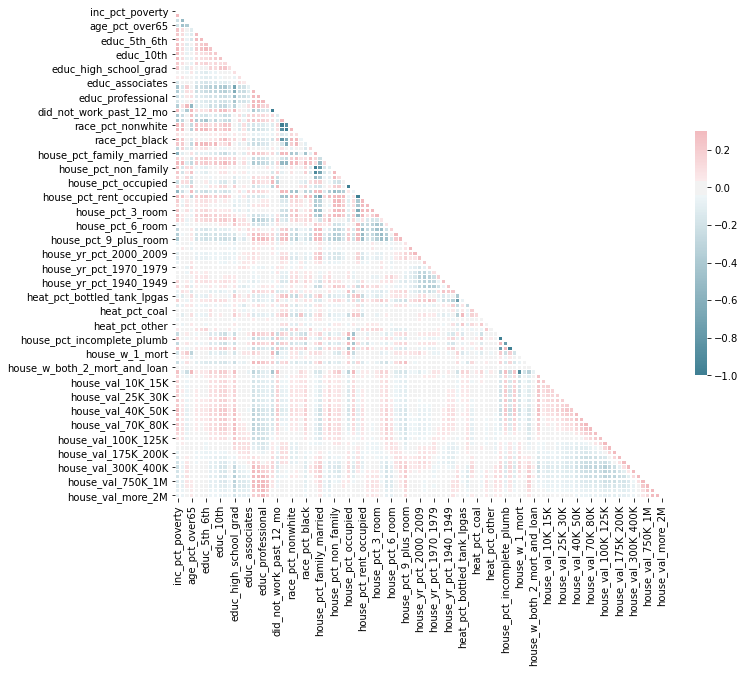

In [281]:
#Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))


# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS_reduced = ACS[['house_yr_pct_earlier_1939','house_yr_pct_1940_1949', 'house_pct_family_married', 'race_pct_white',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene','heat_pct_electricity','house_w_both_2_mort_and_loan', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad','educ_docterate','house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_500K_750K',
           'house_val_20K_25K','house_pct_family_female_hh']]


#From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh','house_no_mort',
                           'race_pct_black','house_pct_live_alone','house_pct_family_married'], axis=1) 





print (ACS.head())


In [286]:
# smoke detector statistical model munging
sm = pd.read_csv(  data_path /'Model Outputs'/'SmokeAlarmModelOutput.csv')
sm['geoid'] = sm['geoid'].str[2:]
sm = sm[ sm['estimate_geography'].isin(['Tract','Block']) ]
sm['tract'] = sm['geoid'].str[:-1]
sm.drop(columns = 'Unnamed: 0', inplace = True)
sm.set_index('geoid', inplace =  True)


In [287]:
#Rurality Data Munging 
rd = pd.read_csv( data_path / 'Master Project Data' /'Tract Rurality Data.csv', dtype = {'FIPS':'object'},encoding = 'latin-1' )
rd['Population Density (per square mile), 2010'] =  rd['Population Density (per square mile), 2010'].str.replace(',','').astype('float')
rd = rd.iloc[:,[0,2,5,6,8]]
block_tract = sm['tract'].to_frame().reset_index()
rd = block_tract.merge(rd, how = 'left', left_on = 'tract' , right_on ='FIPS')
rd.set_index('geoid',inplace= True)
rd = rd.iloc[:,2:]
rd['Select State'] = rd['Select State'].astype('category')
rd = rd.merge( pd.get_dummies(rd['Select State']), how = 'left', on= 'geoid')
rd = rd.iloc[:,3:]

In [288]:
def train_model(X = rd, y= sm, ACS = pd.DataFrame(),predict ='Presence', modeltype='XGBoost'):
    from scipy.stats import zscore, pearsonr
    from sklearn.metrics import auc, accuracy_score, confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score, r2_score

    assert(predict in ['Presence', 'Working']) 
   
    
    # Define model types & parameters 
    
    if modeltype =='LinearRegression':
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
    if modeltype =='ElasticNet':    
        from sklearn.linear_model import ElasticNet
        model = ElasticNet()
    if modeltype =='Ridge':    
        from sklearn.linear_model import Ridge
        model = Ridge()
    if modeltype =='Lasso':    
        from sklearn.linear_model import Lasso
        model = Lasso()       
        
       
        
    elif modeltype =='XGBoost':
        import xgboost as xgb 
        model = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = 0)
            
  
    if  predict == 'Presence':
        y = y['found_detectors_prc_mean']
    elif predict =='Working':
        y = y['working_detectors_prc_mean']




    # merge in ACS Data into X unless NFIRS-Only model
    if not ACS.empty:
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        X = X.dropna()
        y = y.filter(X.index)
        


        

    # Create 80/20 training/testing set split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )


    # Perform cross-validation 

    #scaler = preprocessing.StandardScaler().fit(X)
    #scaler.transform(X)
    #print ('Cross Val Score:')
    #print(cross_val_score(model, X, y))


    # Standardize features by removing the mean and scaling to unit variance
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)

    
    # Fit model to training set

    model = model.fit(X_train,y_train)


    # Calculate training set performance
    train_predictions = model.predict(X_train)

    print(mean_squared_error(y_train, train_predictions))
   #print (roc_auc_score(y_train, train_prediction_probs[:,1]))


    # Calculate test set performance
    test_predictions = model.predict(X_test)
    print ('Test RMSE: {}'.format(mean_squared_error(y_train, train_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_train, train_predictions)) )
    print ('Test Correlation: {}'.format(pearsonr(y_train, train_predictions)) )
    print ('Test R-squared: {}'.format(r2_score(y_train, train_predictions)) )
  #  print (confusion_matrix(y_test, test_predictions))
  #  print (roc_auc_score(y_test, test_prediction_probs[:,1]))
  #  print (classification_report(y_test,test_predictions))
  #  print (log_loss(y_test,test_predictions))


    #Calculate feature importance for each model
    if modeltype == 'XGBoost':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]])) 


    return  model,X_test,y_test



In [289]:
mdl,X_test,y_test = train_model(X = rd, y = sm , ACS = ACS  ,modeltype= 'XGBoost')

224.56648046088318
Test RMSE: 14.985542381271463
Test MAE: 11.694617700609186
Test Correlation: (0.7947919033827024, 0.0)
Test R-squared: 0.55624691927494
Feature ranking:
1. AZ (0.046543)
2. MN (0.045597)
3. LA (0.030634)
4. IN (0.027554)
5. KS (0.024030)
6. ME (0.023485)
7. CT (0.023446)
8. CO (0.022450)
9. SD (0.022149)
10. KY (0.021668)
11. ND (0.019928)
12. TN (0.017812)
13. MT (0.017735)
14. NV (0.017133)
15. GA (0.016742)
16. CA (0.016626)
17. NY (0.015832)
18. SC (0.014807)
19. NJ (0.013665)
20. FL (0.013389)
21. MS (0.012477)
22. PA (0.012090)
23. AK (0.011828)
24. TX (0.011182)
25. NC (0.011096)
26. MA (0.010041)
27. NE (0.009892)
28. HI (0.009365)
29. AL (0.008175)
30. RI (0.007497)
31. IA (0.006984)
32. AR (0.006801)
33. heat_pct_fueloil_kerosene (0.006676)
34. heat_pct_electricity (0.006615)
35. house_val_500K_750K (0.006423)
36. MI (0.006299)
37. house_yr_pct_earlier_1939 (0.006250)
38. house_val_30K_35K (0.006236)
39. house_val_more_2M (0.005934)
40. heat_pct_coal (0.005

In [290]:
mdl,X_test,y_test =train_model(X = rd, y = sm , ACS = ACS_reduced  ,modeltype= 'XGBoost')

273.8619277537728
Test RMSE: 16.548774206985023
Test MAE: 12.922048764845572
Test Correlation: (0.7232761648547277, 0.0)
Test R-squared: 0.4634420119118118
Feature ranking:
1. MN (0.067466)
2. KS (0.060994)
3. AZ (0.056594)
4. LA (0.048214)
5. KY (0.044128)
6. SD (0.039059)
7. ME (0.034789)
8. CO (0.034477)
9. TN (0.030323)
10. GA (0.026867)
11. ND (0.025448)
12. NV (0.025420)
13. IN (0.024047)
14. NY (0.023586)
15. CA (0.022516)
16. AK (0.022011)
17. NJ (0.021912)
18. MS (0.021764)
19. MT (0.019829)
20. FL (0.017700)
21. TX (0.017424)
22. CT (0.016317)
23. SC (0.015784)
24. HI (0.014678)
25. NE (0.014009)
26. PA (0.013129)
27. OH (0.012291)
28. IA (0.011470)
29. RI (0.010333)
30. MO (0.009196)
31. MA (0.009068)
32. MI (0.009064)
33. OR (0.008569)
34. house_val_500K_750K (0.008232)
35. MD (0.007927)
36. NC (0.007631)
37. race_pct_white (0.007548)
38. AL (0.007188)
39. heat_pct_electricity (0.007124)
40. heat_pct_fueloil_kerosene (0.007053)
41. educ_bachelors (0.006905)
42. educ_doctera